In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

c:\Users\LAPSHOP\anaconda3\envs\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
Jobs = pd.read_csv("JobsFE.csv")

In [3]:
# Combine relevant columns into a single text column
Jobs["job_text"] = (
    Jobs["position"].astype(str) + " " +
    Jobs["job_role_and_duties"].astype(str) + " " +
    Jobs["requisite_skill"].astype(str)
)

In [4]:
# Initialize SBERT model
MODEL = SentenceTransformer("paraphrase-MiniLM-L6-v2", device="cpu")
job_texts = Jobs["job_text"].tolist()
job_embeddings = MODEL.encode(job_texts, convert_to_numpy=True)
job_embeddings = job_embeddings / np.linalg.norm(job_embeddings, axis=1, keepdims=True)


#### Perform DBSCAN clustering

In [5]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can tune these parameters
cluster_labels = dbscan.fit_predict(job_embeddings)

In [6]:
# Add the cluster labels as a new column to the dataset
Jobs["cluster"] = cluster_labels

# Optionally, handle noise points (cluster label -1)
Jobs["cluster"] = Jobs["cluster"].apply(lambda x: x if x != -1 else "noise")


In [7]:
# Save the updated dataset with cluster labels
Jobs.to_csv("Jobs_with_clusters_DBSCAN.csv", index=False)

### Example resume text

In [8]:
resume_text = """Yomna Waleed Elsayed Ahmed Hassan
Junior machine learning engineering
yomnawaleed2002@gmail.com
EGYPT, AlGharbia goverment, tanta city.
Yomna Waleed
yomna_waleed
+201118064546
19/05/2002
YomnaWaleed
yomna_waleed
EDUCATION
Faculty of Engineering, Department of Computers and Control, Tanta university 2020 – 2025
Tanta, Egypt
TRAINING
Manara Tech 04/2023 – present
PROFILE
I am a dedicated engineering student specializing in Computer and Automatic Control, with a strong academic background and practical experience in
programming and software development. I excelled in my coursework, achieving an excellent degree in my second year and a very good grade in my
first year. I have a solid foundation in Python programming and libraries essential for data science and machine learning, including NumPy, pandas,
and Matplotlib. My participation in the International Collegiate Programming Contest (ICPC) as a team leader has further honed my problem-solving
skills.
I am actively expanding my expertise in machine learning (ML), particularly in Natural Language Processing (NLP) and Generative AI, having
completed supervised machine learning courses and gained practical experience with various deep learning architectures, including DNNs, RNNs, and
CNNs. My background also includes full-stack development using React.js and Node.js, enabling me to effectively integrate machine learning models
into web applications.
SKILLS
Programming Languages & Technologies:
•Python: Proficient
•C++: Proficient
•React.js: Competent
•Node.js: Amateur
•HTML/CSS: Competent
Data Structures & Algorithms
•Proficient in implementing algorithms and data structures in Python
and C++
•Strong foundation in problem-solving techniques, demonstrated
through participation in competitive programming
Machine Learning & Data Science:
•Libraries: NumPy, pandas, Matplotlib (Competent)
•Machine Learning: Supervised learning (regression, classification)
using Scikit-learn (Competent)
•Deep Learning: Familiar with TensorFlow and PyTorch (Amateur)
•Architectures: DNN, RNN, CNN, Object Detection, Word Detection,
Transfer Learning (Amateur)
•Generative AI: Currently learning (Amateur)
SOFT SKILLS
Project management and leadership
While I was working on the maze game project, I managed to divide the
tasks among the group, although this was challenging because we chose
a three-dimensional game that was beyond what we had learned.
Thinking outside the box
"While choosing a project, I always try to challenge myself and attempt
something that is difficult for others to implement, such as selecting a
three-dimensional game instead of a two-dimensional one, despite the
difficulty of it. I successfully completed the game."
PROJECTS
Email-SMS-Spam-Classifier, Developed a supervised machine learning model to classify emails and SMS messages as
spam or not using Python and Scikit-learn.
08/2024 – 08/2024
Egypt-House-Price-Prediction--Regression-Project, Built a regression model to predict house prices based on
various features, implemented with an HTML interface for user interaction.
08/2024 – 08/2024
Nonogram Puzzle, Created a Nonogram puzzle generator that utilizes backtracking methods and a CSP approach to
solve generated puzzles. My contribution was in developing the solver algorithm.
2024
3d maze game, Developed a 3D maze game using OpenGL and Python, where players navigate to collect coins and solve
puzzles. My role included building the player's movement mechanics and 3D interactions.
2023
Railway Ticket booking, Designed and implemented a train ticket booking system using Node.js, React.js, and MS SQL
for database management, allowing users to book and cancel tickets.
2023
simple memory gain, Created a memory game using React.js that challenges users to find pairs of matching images. 2023
CERTIFICATES
ICPC Qualification 2022
Problem Solving
Back-end enineering using Nodejs and Express
Ideal Student Recognition
ICPC qualification 2023
Zero to Hero in Front-end Development with React
Fullstack Engineering with React and Node.js
Volunteer Work at College and University
LANGUAGES
English
EF SET English Certificate
French"""

In [9]:
# Encode the resume text
resume_embedding = MODEL.encode([resume_text], convert_to_numpy=True)

In [10]:
# Predict the cluster of the resume
nn = NearestNeighbors(n_neighbors=1)
nn.fit(job_embeddings)
_, nearest_index = nn.kneighbors(resume_embedding)
resume_cluster = cluster_labels[nearest_index[0][0]]

print(f"The resume belongs to cluster: {resume_cluster}")

The resume belongs to cluster: 217


#### Function to evaluate model results using DBSCAN

In [11]:
def evaluate_model_results(recommended_jobs, resume_cluster):
    """
    Evaluates the model results by checking how many recommended jobs
    belong to the same cluster as the resume.
    """
    # Extract cluster labels of recommended jobs
    recommended_clusters = []
    for job in recommended_jobs:
        job_id = job["Job Id"]  # Ensure "Job Id" is the correct key
        cluster = Jobs.loc[Jobs["Job Id"] == job_id, "cluster"].values[0]
        recommended_clusters.append(cluster)

    # Calculate cluster purity
    cluster_purity = np.sum(np.array(recommended_clusters) == resume_cluster) / len(recommended_clusters)

    print(f"Clusters of recommended Jobs: {recommended_clusters}")
    print(f"Cluster of resume is {resume_cluster}")
    print(f"Percentage of recommended jobs in the same cluster: {cluster_purity:.2%}")
    return cluster_purity

### calculate the accuracy of SBERT model 

In [12]:
from SBERTmodel import JobRecommendationSystem

In [13]:
# Load the system with job data
import time
import json
start = time.time()
recommender_SBERT = JobRecommendationSystem("Jobs_with_clusters_DBSCAN.csv")
recommended_jobs_SBERT = recommender_SBERT.recommend_jobs(resume_text, top_n=20)
end = time.time()
print(f" the Execution of SBERT model is {end - start}")


Loaded job data with columns: Index(['Job Id', 'workplace', 'working_mode', 'salary', 'position',
       'job_role_and_duties', 'requisite_skill', 'offer_details', 'job_text',
       'cluster'],
      dtype='object')
 the Execution of SBERT model is 175.79354429244995


In [14]:
#call the evaluation metrics 
SBERT_cluster_Purity = evaluate_model_results(recommended_jobs_SBERT["recommended_jobs"], resume_cluster)
print(f"Cluster Purity: {SBERT_cluster_Purity:.2%}")

Clusters of recommended Jobs: [273, 217, 217, 217, 217, 217, 273, 217, 217, 217, 217, 217, 273, 217, 217, 18, 273, 217, 273, 18]
Cluster of resume is 217
Percentage of recommended jobs in the same cluster: 65.00%
Cluster Purity: 65.00%


In [15]:
recommended_jobs_SBERT

{'recommended_jobs': [{'Job Id': 504684777682935,
   'workplace': 'cairo egypt',
   'working_mode': 'temporary',
   'salary': 93000.0,
   'position': 'data analyst',
   'job_role_and_duties': 'apply machine learning algorithms and statistical techniques to extract insights from large datasets develop predictive models conduct data experiments and ab testing data scientistdata scientists use their expertise in data analysis and machine learning to extract valuable insights and predictions from data they build and train models conduct statistical analysis and communicate findings to drive datadriven decisionmaking in the organization',
   'requisite_skill': 'machine learning algorithms and libraries eg scikitlearn tensorflow pytorch statistical analysis and modeling data preprocessing and cleaning big data technologies eg hadoop spark data visualization strong programming skills python r 0 to 10 years mcom',
   'offer_details': 'flexible spending accounts fsas relocation assistance legal

### calculate the accuracy of FASTTEXT model 

In [32]:
from FastText.FastTextmodel import JobRecommendationSystem

In [33]:
# Load the system with job data
import time
import json
start = time.time()
recommender = JobRecommendationSystem("Jobs_with_clusters_DBSCAN.csv")
recommended_jobs = recommender.recommend_jobs(resume_text, top_n=20)

In [34]:
end = time.time()
print(f" the Excution time is {end - start}")

 the Excution time is 1419.2922155857086


In [35]:
recommended_jobs

{'recommended_jobs': [{'Job Id': 1864531249145412,
   'workplace': 'accra ghana',
   'working_mode': 'intern',
   'salary': 76000.0,
   'position': 'teacher',
   'job_role_and_duties': 'specialize in a particular subject area and develop curriculum materials provide expertise and guidance to other educators stay updated on educational trends and research subject matter experta subject matter expert possesses deep knowledge in a specific field and provides expertise to solve complex problems or guide decisionmaking within that domain',
   'requisite_skill': 'expertise in a specific subject area knowledge of curriculum standards instructional design assessment development educational technology proficiency 3 to 14 years btech',
   'offer_details': 'casual dress code social and recreational activities employee referral programs health and wellness facilities life and disability insurance',
   'job_text': 'accra ghana intern teacher specialize in a particular subject area and develop curri

In [36]:
#call the evaluation metrics 
FastText_cluster_Purity = evaluate_model_results(recommended_jobs["recommended_jobs"], resume_cluster)
print(f"Cluster Purity: {FastText_cluster_Purity:.2%}")

Clusters of recommended Jobs: [296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296]
Cluster of resume is 217
Percentage of recommended jobs in the same cluster: 0.00%
Cluster Purity: 0.00%


### calculate the accuracy of BM25 

In [28]:
from BM25model import JobRecommendationSystem

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LAPSHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LAPSHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LAPSHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# Load the system with job data
import time
import json
start = time.time()
recommender_BM25 = JobRecommendationSystem("Jobs_with_clusters_DBSCAN.csv")
recommended_jobs_BM25 = recommender_BM25.recommend_jobs(resume_text, top_n=20)
end = time.time()
print(f"the time of excution is {end - start}")

Loaded job data with columns: Index(['Job Id', 'workplace', 'working_mode', 'salary', 'position',
       'job_role_and_duties', 'requisite_skill', 'offer_details', 'job_text',
       'cluster'],
      dtype='object')
the time of excution is 383.11133003234863


In [30]:
recommended_jobs_BM25

{'recommended_jobs': [{'Job Id': 1384036741810650,
   'workplace': 'budapest hungary',
   'working_mode': 'contract',
   'salary': 78000.0,
   'position': 'data scientist',
   'job_role_and_duties': 'develop machine learning models and algorithms for data analysis and prediction preprocess and clean data for model training evaluate model performance and finetune parameters machine learning engineermachine learning engineers develop machine learning models and algorithms working on tasks like data preprocessing model training and deployment',
   'requisite_skill': 'machine learning algorithms python programming data preprocessing deep learning model evaluation 2 to 13 years bca',
   'offer_details': 'employee referral programs financial counseling health and wellness facilities casual dress code flexible spending accounts fsas',
   'job_text': 'budapest hungary contract data scientist develop machine learning models and algorithms for data analysis and prediction preprocess and clean da

In [31]:
#call the evaluation metrics 
BM25_cluster_Purity = evaluate_model_results(recommended_jobs_BM25["recommended_jobs"], resume_cluster)
print(f"Cluster Purity: {BM25_cluster_Purity:.2%}")

Clusters of recommended Jobs: [217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217]
Cluster of resume is 217
Percentage of recommended jobs in the same cluster: 100.00%
Cluster Purity: 100.00%


### calculate the accuracy of TF-IDF 

In [16]:
from TFIDFmodel import JobRecommendationSystem

In [17]:
# Load the system with job data
import time
import json
start = time.time()
recommender_TFIDF = JobRecommendationSystem("Jobs_with_clusters_DBSCAN.csv")
recommended_jobs_TFIDF = recommender_TFIDF.recommend_jobs(resume_text, top_n=20)
end = time.time()
print(f"the time of excution is {end - start}")

the time of excution is 2.0615837574005127


In [18]:
recommended_jobs_TFIDF

{'recommended_jobs': [{'Job Id': 2716774249506789,
   'workplace': 'belmopan belize',
   'working_mode': 'temporary',
   'salary': 70000.0,
   'position': 'data scientist',
   'job_role_and_duties': 'develop machine learning models and algorithms for data analysis and prediction preprocess and clean data for model training evaluate model performance and finetune parameters machine learning engineermachine learning engineers develop machine learning models and algorithms working on tasks like data preprocessing model training and deployment',
   'requisite_skill': 'machine learning algorithms python programming data preprocessing deep learning model evaluation 5 to 10 years mca',
   'offer_details': 'legal assistance bonuses and incentive programs wellness programs employee discounts retirement plans',
   'job_text': 'data scientist develop machine learning models and algorithms for data analysis and prediction preprocess and clean data for model training evaluate model performance and 

In [19]:
#call the evaluation metrics 
TFIDF_cluster_Purity = evaluate_model_results(recommended_jobs_TFIDF["recommended_jobs"], resume_cluster)
print(f"Cluster Purity: {TFIDF_cluster_Purity:.2%}")

Clusters of recommended Jobs: [217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217]
Cluster of resume is 217
Percentage of recommended jobs in the same cluster: 100.00%
Cluster Purity: 100.00%


### calculate the accuracy of KNN model 

In [20]:
from KNNmodel import JobRecommendationSystem

In [21]:
# Load the system with job data
import time
start = time.time()
recommender_KNN = JobRecommendationSystem("Jobs_with_clusters_DBSCAN.csv")
recommended_jobs_KNN = recommender_KNN.recommend_jobs(resume_text, top_n=20)
end = time.time()
print(f"the time of excution is {end - start}")

the time of excution is 7.322688102722168


In [22]:
recommended_jobs_KNN

{'recommended_jobs': [{'Job Id': 2704243050080316,
   'workplace': 'juba south sudan',
   'working_mode': 'full-time',
   'salary': 80000.0,
   'position': 'data scientist',
   'job_role_and_duties': 'develop machine learning models and algorithms for data analysis and prediction preprocess and clean data for model training evaluate model performance and finetune parameters machine learning engineermachine learning engineers develop machine learning models and algorithms working on tasks like data preprocessing model training and deployment',
   'requisite_skill': 'machine learning algorithms python programming data preprocessing deep learning model evaluation 4 to 9 years btech',
   'offer_details': 'transportation benefits professional development bonuses and incentive programs profitsharing employee discounts',
   'job_text': 'data scientist develop machine learning models and algorithms for data analysis and prediction preprocess and clean data for model training evaluate model per

In [23]:
#call the evaluation metrics 
KNN_cluster_Purity = evaluate_model_results(recommended_jobs_KNN["recommended_jobs"], resume_cluster)
print(f"Cluster Purity: {KNN_cluster_Purity:.2%}")

Clusters of recommended Jobs: [217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217]
Cluster of resume is 217
Percentage of recommended jobs in the same cluster: 100.00%
Cluster Purity: 100.00%


### calculate the accuracy of LDA model 

In [24]:
from LDAmodel import JobRecommendationSystem

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LAPSHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LAPSHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LAPSHOP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Load the system with job data
import time
start = time.time()
recommender_LDA = JobRecommendationSystem("Jobs_with_clusters_DBSCAN.csv")
recommended_jobs_LDA = recommender_LDA.recommend_jobs(resume_text, top_n=20)
end = time.time()
print(f"the time of excution is {end - start}")

Index(['Job Id', 'workplace', 'working_mode', 'salary', 'position',
       'job_role_and_duties', 'requisite_skill', 'offer_details', 'job_text',
       'cluster'],
      dtype='object')
the time of excution is 165.5714967250824


In [26]:
recommended_jobs_LDA

{'recommended_jobs': [{'Job Id': 263355463685801,
   'position': 'systems analyst',
   'job_role_and_duties': 'analyze business systems processes and requirements to identify it solutions develop system specifications and requirements documents collaborate with it teams to implement solutions it analystan it analyst assesses and analyzes it systems identifying areas for improvement implementing technology solutions and providing technical support to users and departments',
   'similarity_score': 0.9163402318954468},
  {'Job Id': 3088436589938023,
   'position': 'systems analyst',
   'job_role_and_duties': 'analyze business systems processes and requirements to identify it solutions develop system specifications and requirements documents collaborate with it teams to implement solutions it analystan it analyst assesses and analyzes it systems identifying areas for improvement implementing technology solutions and providing technical support to users and departments',
   'similarity_scor

In [27]:
#call the evaluation metrics 
LDA_cluster_Purity = evaluate_model_results(recommended_jobs_LDA["recommended_jobs"], resume_cluster)
print(f"Cluster Purity: {LDA_cluster_Purity:.2%}")

Clusters of recommended Jobs: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 79]
Cluster of resume is 217
Percentage of recommended jobs in the same cluster: 0.00%
Cluster Purity: 0.00%


#### plot the result (time and accuracy ) of six models 

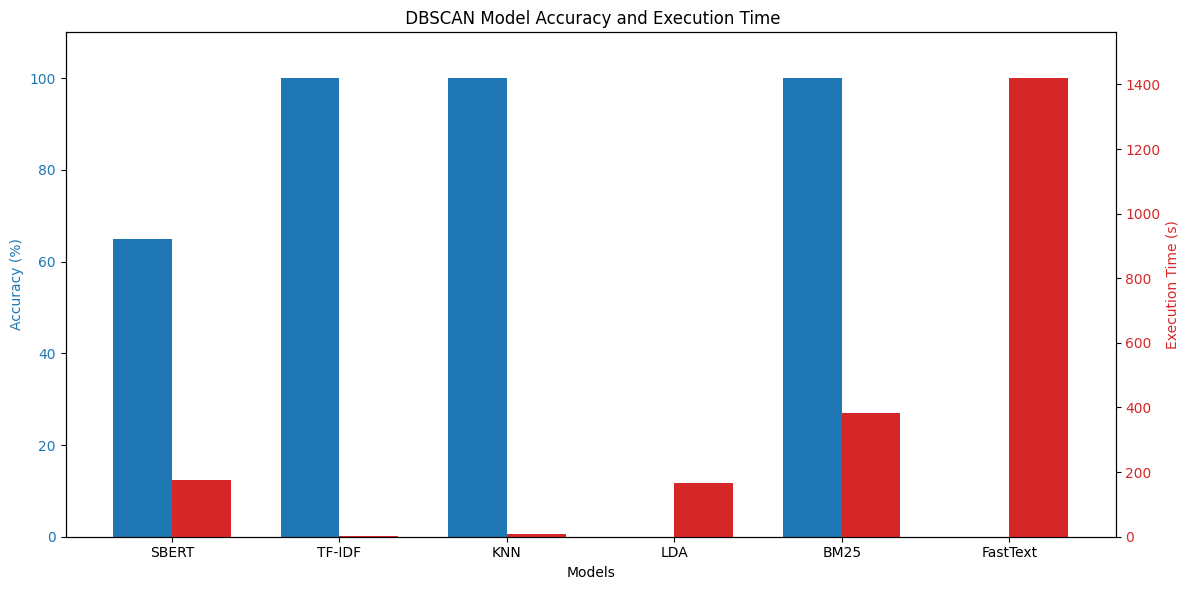

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data for accuracy and execution time
models = ['SBERT', 'TF-IDF', 'KNN', 'LDA', 'BM25', 'FastText']
accuracy = [65.00, 100.00, 100.00, 0.00, 100.00, 0.00]  # Accuracy in percentage
execution_time = [175.79, 2.06, 7.322, 165.57, 383.111, 1419.29]  # Execution time in seconds

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for accuracy
color = 'tab:blue'
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy (%)', color=color)
ax1.bar(x - width/2, accuracy, width, label='Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 110)  # Set y-axis limit for accuracy

# Bar plot for execution time
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Execution Time (s)', color=color)
ax2.bar(x + width/2, execution_time, width, label='Execution Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, max(execution_time) * 1.1)  # Set y-axis limit for execution time

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title(' DBSCAN Model Accuracy and Execution Time')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Show the plot
plt.show()